<h7>Design and code by Sabir Jana, 2020

Pairs trading is a market-neutral strategy where we use statistical techniques to identify two stocks that are historically highly correlated with each other. When there is a deviation in the price relationship of these stocks, we expect this to be mean reverting and buy the underperforming stock and simultaneously sell the outperforming one. If our mean-reversion assumption is valid then prices should converge to long term average and trade should benefit. However, if the price divergence is not temporary and it is due to structural reasons then there is a high risk of losing the money.</h7>


<h3>Exercise 2C
    Pair trading and the z-score; continued from exercise 1B</h3>

In this exercise, we practice pair trading. There are several versions of pair trading. In this exercise, we will use the z-score of the ratio between the two stock prices to generate trading signals and set the upper and lower thresholds. This will tell us how far a price is from the population mean value. If it is positive and the value is above the upper threshold, the asset price is higher than the price average. Therefore, its price is expected to fall, so we want to sell (short) this asset and buy (buy) the other asset. Pairs trading is typically immune to changes in the whole market. 

The main steps are: 

Preparing data

1. we choose and clean the data,
2. we split the data in learning data and test data. 

Using train data to find cointegrated stocks:

3. we compute the correlation and cointegration between different assets using the learning data. Choose two assets (asset1 and asset2) that is highly cointegrated. 

4. Using Ordinary Least-Square regression, we compute a hedge ratio H for asset1. Then, we take long and short positions: asset2- H * asset1.

Testing the trading strategy with test data:

5. We compute z-score and set the upper and lower thresholds based on the z-score generate trading signals.
example: Let us consider asset2. Assume that it is a lot above the long-time average. We expect its price to fall. We take a short position in it. As keep a market neutral position, we go long with asset1. 

6. We compute the Profits and losses of this strategy. 

IMPORTANT: you don't need to follow the instructions, steps and pieces of code presented in this file. You can alse design your own solution. 


In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# %pip install --upgrade seaborn
print(f"Seaborn version: {sns.__version__}")
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline


Seaborn version: 0.13.2


<h4> Preparing data

In [10]:
import glob

# Concatenate all historicalData csv files
all_files = glob.glob("HistoricalData*.csv")
dataframes = []

for file in all_files:
    ticker = file.split('_')[1].split('.')[0]  # Extract ticker from filename
    df = pd.read_csv(file)
    df['ticker'] = ticker  # Add ticker column to the dataframe
    dataframes.append(df)

nifty_meta = pd.concat(dataframes, ignore_index=True)
nifty_meta.head(10)

,Date,Close/Last,Volume,Open,High,Low,ticker
0,02/14/2025,$113.10,32477160,$112.65,$114.63,$111.70,AMD
1,02/13/2025,$111.81,40911800,$112.00,$114.60,$110.40,AMD
2,02/12/2025,$111.72,25319730,$109.52,$111.8356,$109.0649,AMD
3,02/11/2025,$111.10,35033760,$108.98,$113.07,$108.94,AMD
4,02/10/2025,$110.48,34905360,$108.44,$111.40,$108.15,AMD
5,02/07/2025,$107.56,46082500,$109.13,$109.92,$106.79,AMD
6,02/06/2025,$110.16,50426590,$110.93,$112.56,$109.02,AMD
7,02/05/2025,$112.01,110609300,$107.61,$112.09,$106.50,AMD
8,02/04/2025,$119.50,69412090,$115.45,$119.85,$114.79,AMD
9,02/03/2025,$114.27,34586050,$113.875,$115.16,$112.98,AMD


In [4]:
tickers = list(nifty_meta[nifty_meta.Industry=='PHARMA'].Symbol)
print(tickers)
print(len(tickers))

['AUROPHARMA', 'BIOCON', 'CADILAHC', 'CIPLA', 'DIVISLAB', 'DRREDDY', 'LUPIN', 'SUNPHARMA']
8


In [5]:
# start and end dates for testing
fromdate = datetime.datetime(2010, 1, 1)
todate = datetime.datetime(2020, 6, 15)

In [ ]:
# create the prices dataframe from nifty_meta
nifty_meta['Date'] = pd.to_datetime(nifty_meta['Date'], format='%m/%d/%Y').dt.strftime('%Y-%m-%d')
nifty_meta['close'] = nifty_meta['Close/Last'].replace({'\$': '', ',': ''}, regex=True).astype(float)
prices = nifty_meta.set_index(['ticker', 'Date']).sort_index()
prices.head(2)

Close/Last    Volume     Open     High      Low   close
ticker Date                                                              
AMD    2024-02-20    $165.69  66549990  $171.14  $171.81  $162.00  165.69
       2024-02-21    $164.29  48774560  $162.74  $164.90  $161.81  164.29

In [28]:
# remove tickers where we have less than 10 years of data.
#min_obs = 2520  # this is 10 years x 250 yearly trading days
#nobs = prices.groupby(level='ticker').size()
#keep = nobs[nobs>min_obs].index

#prices = prices.loc[idx[keep,:], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1743 entries, ('AMD', '2024-02-20') to ('Tesla', '2025-02-14')
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close/Last  1743 non-null   object 
 1   Volume      1743 non-null   int64  
 2   Open        1743 non-null   object 
 3   High        1743 non-null   object 
 4   Low         1743 non-null   object 
 5   close       1743 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 97.3+ KB


In [29]:
# final tickers list
TICKERS = list(prices.index.get_level_values('ticker').unique())
print(len(TICKERS))
print(TICKERS)

7
['AMD', 'Apple', 'Microsoft', 'Nokia', 'Nvidia', 'TSM', 'Tesla']


In [30]:
# unstack and take close price
close = prices.unstack('ticker')['close'].sort_index()
close = close.dropna()
close.head(2)

ticker,AMD,Apple,Microsoft,Nokia,Nvidia,TSM,Tesla
Date,,,,,,,
2024-02-20,165.69,181.56,402.79,3.49,69.452,125.33,193.76
2024-02-21,164.29,182.32,402.18,3.53,67.472,125.34,194.77


Until now, we have organized and cleaned the data. 

Next, we split the close data to train_close and test_close. 

In [31]:
# train test split 
train_close, test_close = train_test_split(close, test_size=0.5, shuffle=False)

In [32]:
# quick view of head and tail of train set
# train_close.head(2)
# train_close.tail(2)

<h4> Using train data to find cointegrated stocks

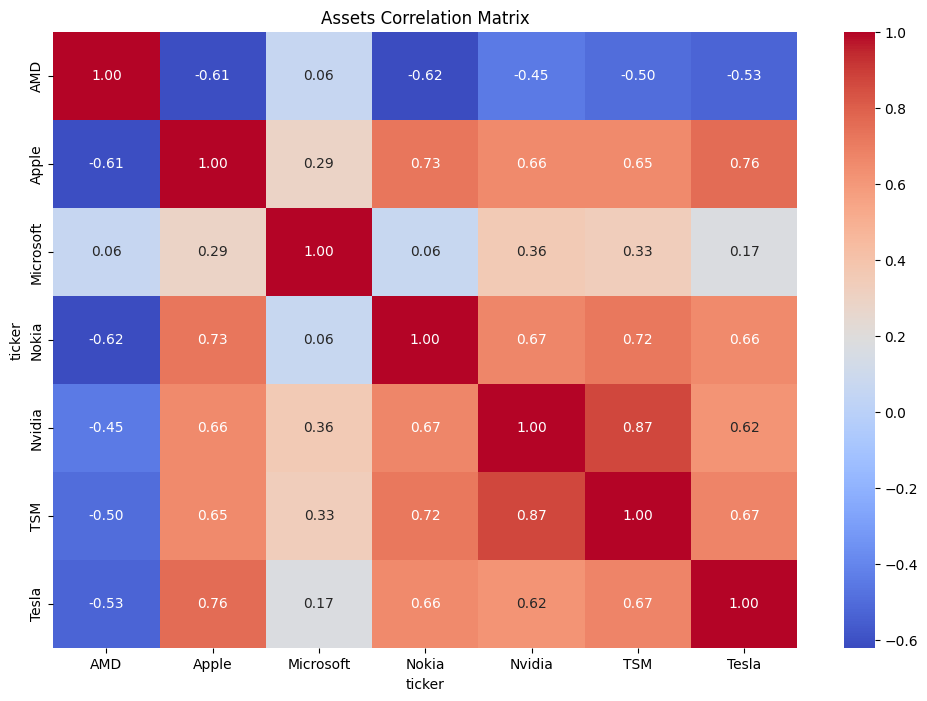

In [18]:
# Pearson correlation to get the basic idea about the relationship
correlation_matrix = train_close.pct_change().corr(method='pearson')
# print(correlation_matrix)

fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(correlation_matrix, 
            ax=ax, 
            cmap='coolwarm', 
            annot=True, 
            fmt=".2f",
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.columns,) #spearman
ax.set_title('Assets Correlation Matrix')
# plt.tight_layout() 
plt.savefig('chart1', dpi=300)
plt.show()

Next, we search cointegrated pairs. The corresponding function is given to you. 
Q4: What is the difference between correlated pairs and cointegrated pairs? Which stocks could form interesting pairs according to the table?

In [40]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] <= 0.10:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

Next, call the function find_cointegrated_pairs using as data the closing train data.  Then, print the pairs. Finally, draw a heatmap of the pvalues between pairs.

In [41]:
# calculate p-values with find_cointegrated_pairs and plot a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)

In [42]:
print("Parit, joiden P-value on pienempi tai yhtäsuuri kuin 0.10:")
for pair in pairs:
    print(f"{pair[0]} - {pair[1]}")

Parit, joiden P-value on pienempi tai yhtäsuuri kuin 0.10:
Nokia - TSM
Nvidia - TSM


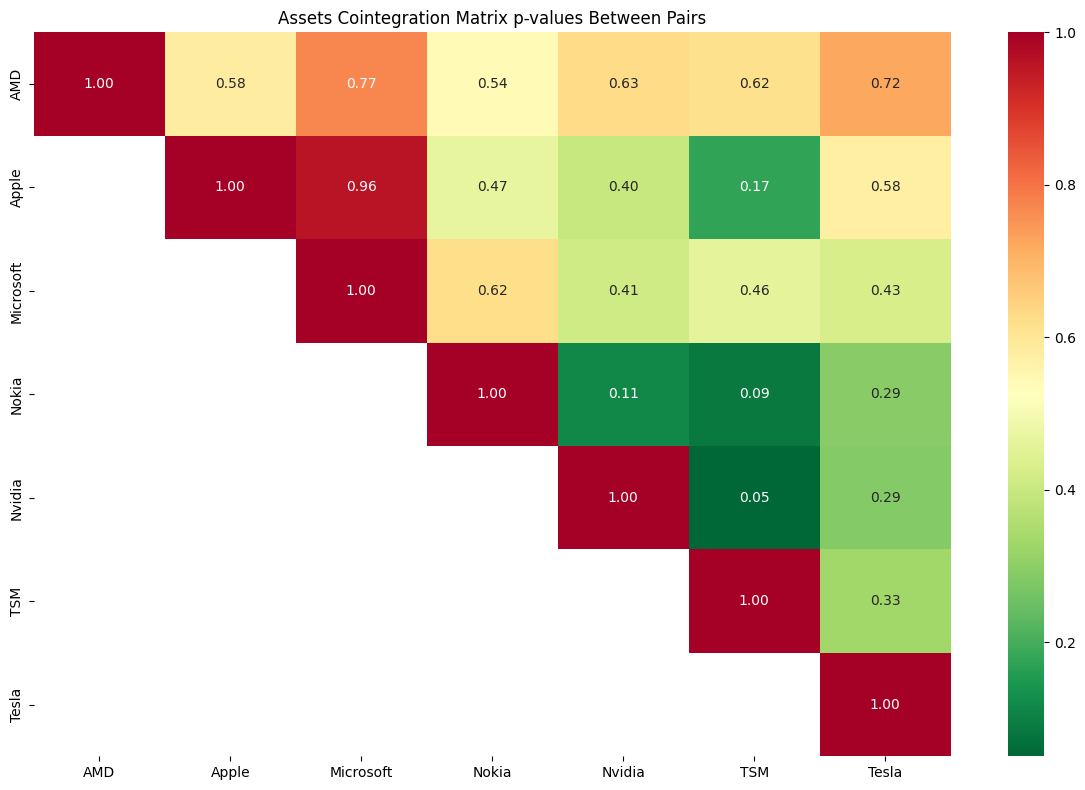

In [43]:
# calculate p-values with find_cointegrated_pairs and plot a heatmap
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pvalues, 
            xticklabels=train_close.columns,
            yticklabels=train_close.columns, 
            cmap='RdYlGn_r', 
            annot=True, 
            fmt=".2f",
            mask=np.tril(np.ones_like(pvalues), k=-1))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=300)
plt.show()

Based on the cointegration heatmap, choose two assets. 

In [44]:
# based on the cointegration heatmap above, choose two assets
asset1='Nvidia'
asset2='TSM'


In [45]:
# create a dataframe called 'train' consisting of two columns: the closing prices of asset1 and asset2. 
train = pd.DataFrame(pd.concat([train_close[asset1], train_close[asset2]], axis=1))


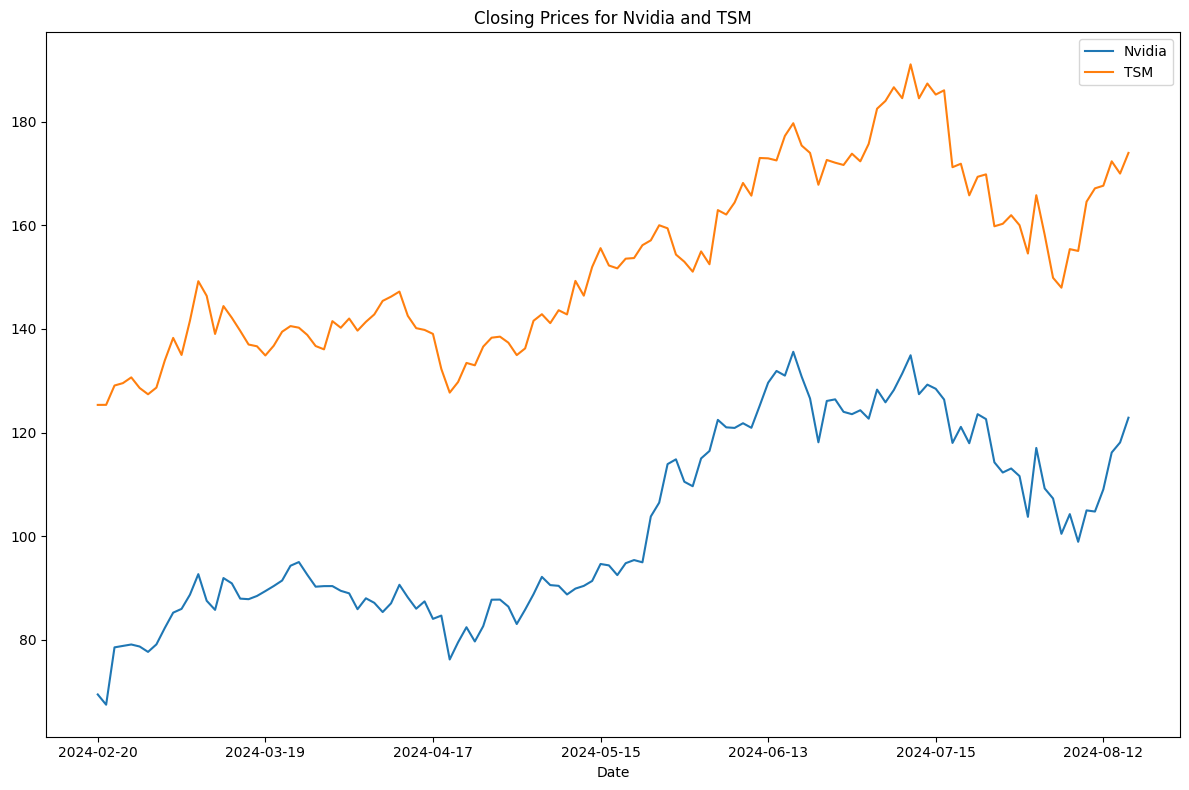

In [46]:
# plot closing prices
fig, ax = plt.subplots(figsize=(12, 8))
train.plot(ax=ax)
ax.set_title(f'Closing Prices for {asset1} and {asset2}')
plt.tight_layout()
plt.savefig('chart3', dpi=300)
plt.show()

Once we have a pair of cointegrated stocks, we take a short position in one of the stocks and a long position in a certain amount H (hedge ratio) of the other stock. Next, we should find out the amount H. We do this by Original Least Square regression. You can look for advice, e.g., from here https://www.statsmodels.org/stable/index.html


In [47]:
# run OLS regression
model=sm.OLS(train[asset2], train[asset1]).fit()

You can also try a robust version of the regression, see https://www.statsmodels.org/stable/rlm.html

In [170]:
#model=sm.RLM(train.asset2, train.asset1).fit()

In [48]:
# print regression summary results using model.summary
summary = model.summary()
print(summary)

                                 OLS Regression Results                                
Dep. Variable:                    TSM   R-squared (uncentered):                   0.994
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                          2.193e+04
Date:                Tue, 18 Feb 2025   Prob (F-statistic):                   1.83e-140
Time:                        14:14:28   Log-Likelihood:                         -478.80
No. Observations:                 124   AIC:                                      959.6
Df Residuals:                     123   BIC:                                      962.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Next, you should find from the table above the hedge ratio H / coefficient for asset 1. You may need 'model.params'.

In [49]:
print('Hedge Ratio = ', model.params.iloc[0])
H = model.params.iloc[0]

Hedge Ratio =  1.4836618094772793


Now, we move to taking a long position in asset2 and a short position in (H * asset1). First, calculate the spread between the long position and the short position. 
 

In [50]:
# calculate spread
spread = train[asset2] - H * train[asset1]

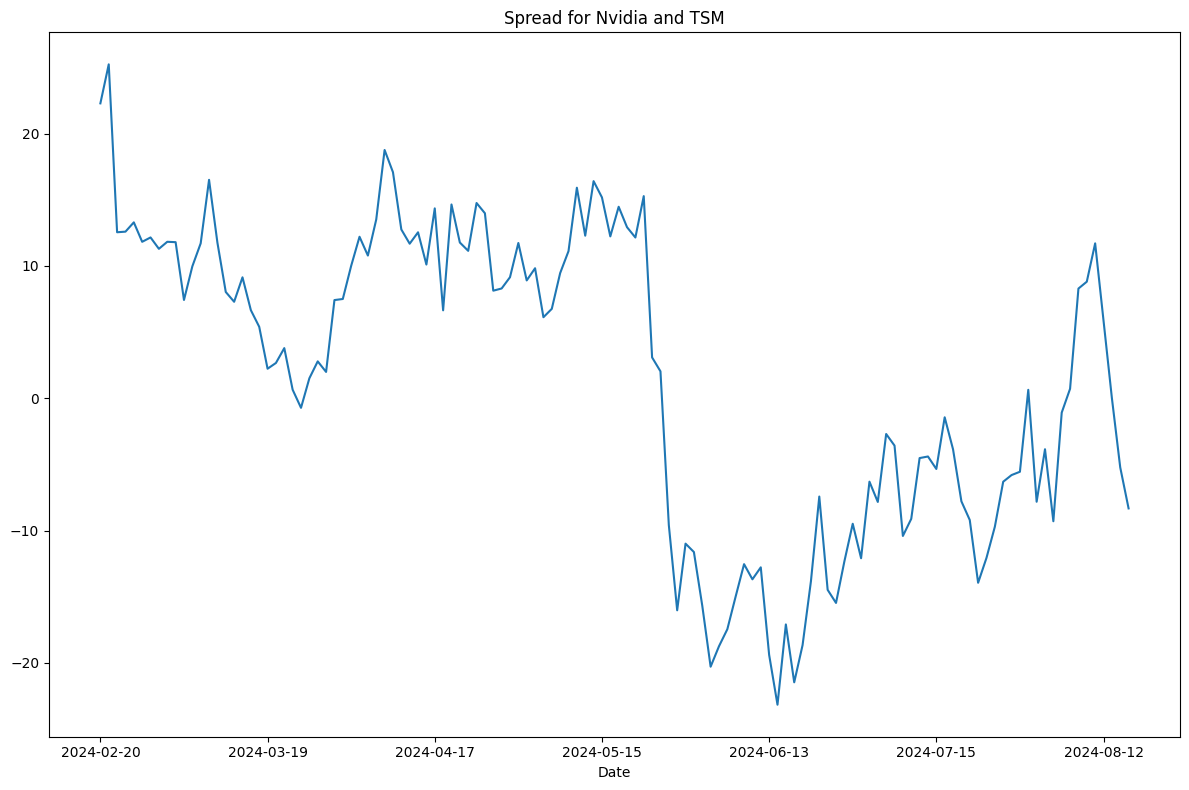

In [51]:
# Plot the spread
fig, ax = plt.subplots(figsize=(12, 8))
spread.plot(ax=ax)
ax.set_title(f'Spread for {asset1} and {asset2}')
plt.tight_layout()
plt.savefig('chart4', dpi=300)
plt.show()

<h4> Testing the trading strategy with test data:

We define a function 'zscore' with input v, returning the z-score z = ( v - μ ) / σ , where v is the value being evaluated, μ is the mean and σ is the standard deviation. 

In [52]:
# calculate z-score
def zscore(series):
    return (series - np.mean(series)) / np.std(series)

We create a dataframe called 'signals' with two columns: 'asset1' = the closing prices of the test data of asset1. 'asset2'  is similar. We then calculate ratios of the closing prices and plot the ratios. Explanation: As the stocks are cointegrated, we assume that there is a long-average mean of this ratio.  When there is a deviation in the ratio (
price relationship of these stocks), we expect this to be mean reverting. We will take a long position the
underperforming stock and a short position in the outperforming one. 

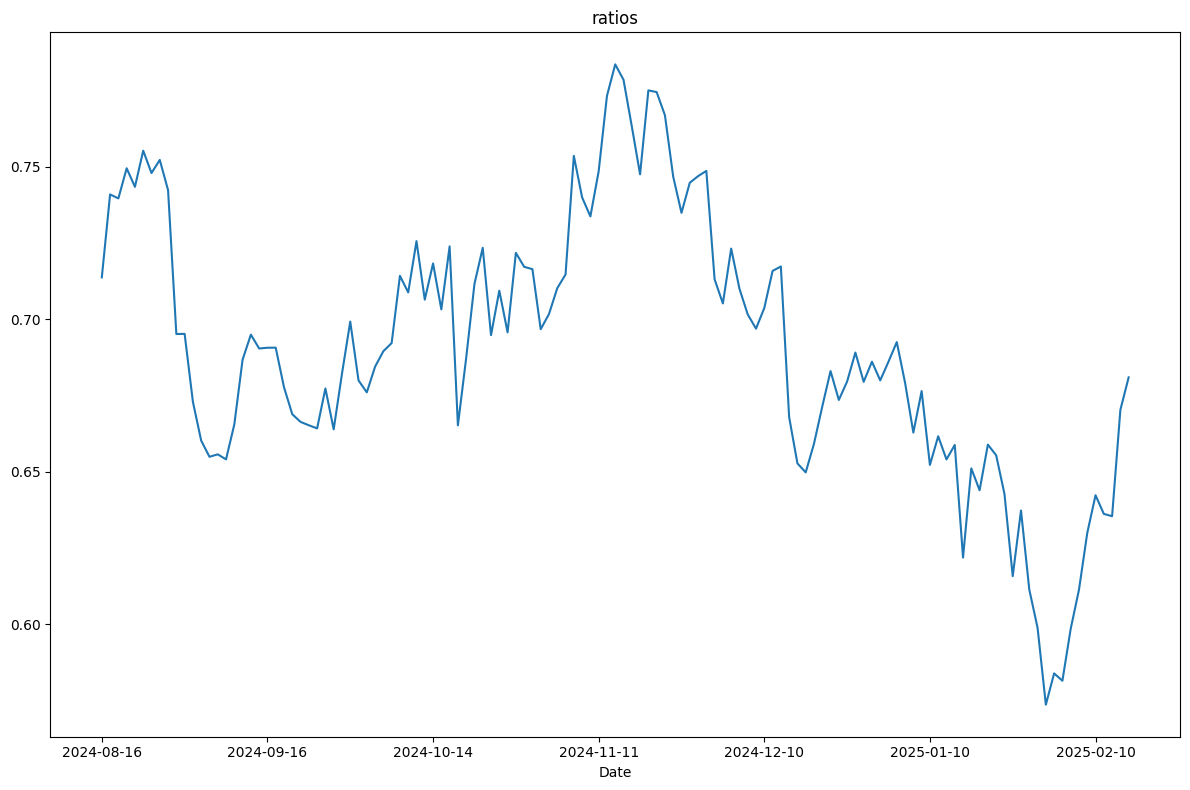

In [53]:
# create a dataframe for trading signals. Compute then the ratio: test data closing price of asset1/asset2. 
signals = pd.DataFrame(pd.concat([test_close[asset1], test_close[asset2]], axis=1))
ratios = signals[asset1]/signals[asset2]

fig, ax = plt.subplots(figsize=(12, 8))
ratios.plot(ax=ax)
ax.set_title(f'ratios')
plt.tight_layout()
plt.savefig('chart5', dpi=300)
plt.show()



Next, we calculate the z-score of the ratios using the function zscore defined above. We add this data as 'z' in the signals dataframe. We compute the upper and lower limit for z. The upper limit is 1 standard deviation above the mean. The lower limit is 1 standard deviation below the mean.

In [54]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = 1.0
signals['z lower limit'] = -1.0

We create in the signals dataframe a new column 'signals1'. This column has values 1 and -1 with the following logic: If z-score is greater than the upper threshold then we will have -1 (short signal). If  z-score is less than the lower threshold then we will have +1 (long signal). The default is zero for no signal (the z-score is within the upper and the lower boundary)

If you need help, this piece of code is given in the end of this python file. 

In [55]:
# create signal - short if z-score is greater than upper limit else long
def generate_signal(z, upper_limit, lower_limit):
    if z > upper_limit:
        return -1
    elif z < lower_limit:
        return 1
    else:
        return 0

signals['signals1'] = np.vectorize(generate_signal)(signals['z'], signals['z upper limit'], signals['z lower limit'])


We create a positions column in 'signals'. We use the first-order difference of the signal column to obtain the stock position. If it is +1 then we go long, -1 then short and 0 if no position.

The second signal is opposite to first as we go long on one stock and simultaneously short on the other one. Similarly, take the first-order difference for the second signal and calculate the second position column. 


In [56]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['positions2'] = -signals['positions1']


In [57]:
# verify dataframe head and tail
print(signals.head(5))
print(signals.tail(5))

            Nvidia     TSM         z  z upper limit  z lower limit  signals1  \
Date                                                                           
2024-08-16  124.58  174.54  0.520413            1.0           -1.0         0   
2024-08-19  130.00  175.45  1.141466            1.0           -1.0        -1   
2024-08-20  127.25  172.04  1.111812            1.0           -1.0        -1   
2024-08-21  128.50  171.44  1.337480            1.0           -1.0        -1   
2024-08-22  123.74  166.44  1.198553            1.0           -1.0        -1   

            positions1  positions2  
Date                                
2024-08-16         NaN         NaN  
2024-08-19        -1.0         1.0  
2024-08-20         0.0        -0.0  
2024-08-21         0.0        -0.0  
2024-08-22         0.0        -0.0  
            Nvidia     TSM         z  z upper limit  z lower limit  signals1  \
Date                                                                           
2025-02-10  133.57  

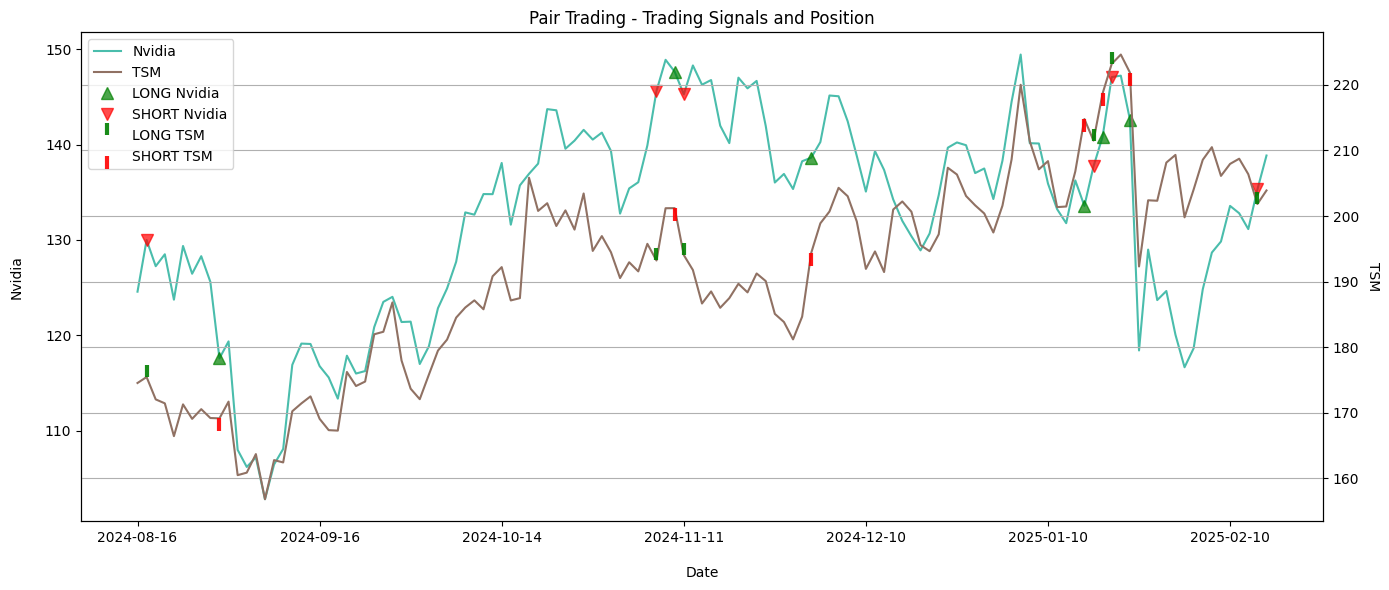

In [ ]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals[asset1], c='#4abdac')
l2, = bx2.plot(signals[asset2], c='#907163')

u1, = bx.plot(signals[asset1][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals[asset1][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals[asset2][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals[asset2][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.set_xticks(signals.index[::20])
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=300);

<h3>Portfolio Profit and Loss Calculation</h3>

We test our trading strategy. The initial capital is 100000. We invest it in asset1 and asset2. To ensure that we will not run out of money, we compute the initial positions using the mximum price of each asset. 

In [65]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals[asset1])
positions2 = initial_capital// max(signals[asset2])
print(positions1, positions2)


669.0 445.0


We calculate holding in the first stock by taking the cumulative sum of its position
multiplied by stock price and the total number of shares. We then calculate the cash position by subtracting holding from the initial cash position. The
total position of stock in the portfolio is the sum of cash plus holding. We calculate daily returns using total stock position.


In [66]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals[asset1]
portfolio['holdings1'] = signals['positions1'].cumsum() * signals[asset1] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1']* signals[asset1] * positions1).cumsum()# portfolio['holdings1']
portfolio['total asset1'] = portfolio['cash1'] + portfolio['holdings1']
portfolio['return1'] = portfolio['total asset1'].pct_change().fillna(0)
portfolio['positions1'] = signals['positions1'].cumsum()

In [67]:
# pnl for the 2nd asset
portfolio['asset2'] = signals[asset2]
portfolio['holdings2'] = signals['positions2'].cumsum() * signals[asset2] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals[asset2] * positions2).cumsum()# portfolio['holdings2']
portfolio['total asset2'] = portfolio['cash2'] + portfolio['holdings2']
portfolio['return2'] = portfolio['total asset2'].pct_change().fillna(0)
portfolio['positions2'] = signals['positions2'].cumsum()

In [68]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

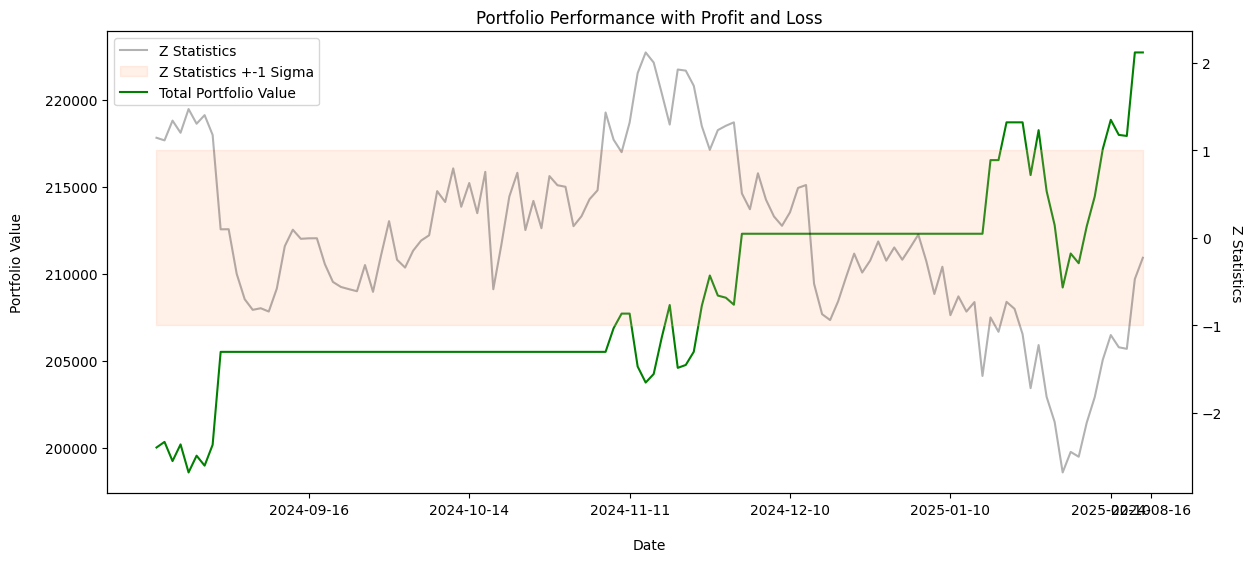

In [70]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.set_xticks(signals.index[::20])
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=300);

In [187]:
def generate_signal(z, upper_limit, lower_limit):
    if z > upper_limit:
        return -1
    elif z < lower_limit:
        return 1
    else:
        return 0

signals['signals1'] = np.vectorize(generate_signal)(signals['z'], signals['z upper limit'], signals['z lower limit'])
